# Using the Auberbach-Kotlikoff Fixed-Point Solver with Adaptive Dampening

### by [Kerk L. Phillips](https://sites.google.com/site/kerkphillips/home), July 2018

The code in this Jupyter notebook was written using Python 3.6.

This notebook explains how to use the Auberbach-Kotlikoff fixed-point solver where the dampeing parameter changes as one iterates.  This code and examples can be downloaded at the following Github site.  [https://github.com/kerkphil/DSGE-Utilities](https://github.com/kerkphil/DSGE-Utilities).  Alternatively, this notebook can be found in the public GitHub repository [https://github.com/kerkphil/Jupyter_Notebooks](https://github.com/kerkphil/Jupyter_Notebooks).

Auerbach and Kiotlikoff (1987) showed how to solve a deterministic overlapping generations (OLG) model using a fixed-point solver on the time path of aggregate capital for an economy.  Their algorithm proceeds as follows:

1) Set the counter $i=0$.

2) Take an initial guess for the time path of aggregate capital over a long sample, $\{K^i_t\}_{t=1}^T$.  $T$ needs to be large enough that the economy is effectively at the steady state by time $T$.

3) Calculate the time paths for wages and interest rates $\{w_t, r_t\}_{t=1}^T$ given aggregate capital.

4) For all households in all periods, calculate optimal savings given these prices.

5) Aggregate the savings of all households each period to get a new measure of the capital stock each period, $\{\hat K_t\}_{t=1}^T$.

6) Calculate the difference between $\{K^i_t\}_{t=1}^T$ and $\{\hat K_t\}_{t=1}^T$.

7) If the difference is close to zero, end the solver, the transition path has been found.  Otherwise update the guess for the time path using $\{K^{i+1}_t\}_{t=1}^T = \xi \{\hat K_t\}_{t=1}^T + (1-\xi) \{K^i_t\}_{t=1}^T$, increment $i = i + 1$ and return to step 2)

It is well-known that for a value of $0 < \xi \le 1$ sufficiently small this proceedure will eventually converge to a fixed-point.

However, the smaller $\xi$ is the longer the algorithm takes to converge.  If $\xi$ is too large, the algorithm may diverge.

One way to speed up convergence is to adopt a value of $xi$ that changes with each iteration.  A simple way to do this is to examine the difference $\Delta^i \equiv || \{K^i_t\}_{t=1}^T - \{\hat K_t\}_{t=1}^T ||$ each iteration.  If $\Delta$ rises from one iteration to the next, we will reduce the dampener as this is signal that the algorithm may be diverging.  If the value of $\Delta$ falls, we can increase the dampener slightly to speed up convergence.

$$ \xi^{i+1} = \left\{ \begin{matrix} \lambda_1 \xi^i & \text{if } \Delta^i > \Delta^{i-1} \\ \max(\lambda_2 \xi^i, 1) & \text{if } \Delta^i \le \Delta^{i-1} \end{matrix} \right.;\; \lambda_1 < 1 < \lambda_2 $$

The following function implements this idea.

The code for this is available at [https://github.com/kerkphil/DSGE-Utilities](https://github.com/kerkphil/DSGE-Utilities), but we reproduce that code in the cell below.

In [1]:
import numpy as np

def AKsolve(Xguess, funcname, fparams, ccrit, damp, maxiter, shrinkon, \
    shrink, expandon, expand, disttype, display):
    '''
    This function performs the Auerbach-Kotlikoff contraction mapping on a 
    function.
    
    The inputs are:
        Xguess:  An initial guess for the fixed point. Can be a scalar or
            matrix.
        funcname:  Ahe name of the python function.  It must take Xvalue as an
            argument with the same dimensions as Xguess, with fparams as 
            parameters and return a new value for X, Xnew.        
        fparams:  A list of parameters used by funcname
        ccrit:  The value for distance between Xvalue and Xnew that indicates
            convergence to the fixed point
        damp:  The weight put on Xnew relative to Xvalue when moving to the
            next iteration; Xvalue = damp*Xnew + (1-damp)*Xvalue.
        maxiter:  The maximum number of iterations allowed
        shrinkon:  If true, the value of damp is scaled down when the distance
            between values of X in an iteration increases.
        shrink:  The factor by which damp shrinks.
        expandon:  If true, the value of damp is scaled up when the distance
            between values of X in an iteration does not increase.
        expand:  The factor by which damp expands.
        disttype:  Indicator variable for the method used to compute distance
            between Xvalue and Xnew
            1: root mean squared differences  (default)
            2: mean absolute deviation
            3: maximum absolute deviation
        display:  If true, display iterations.
    
    The outputs are the fixed point, the last iteration's distanceand the
        number of iterations performed
    '''
    # initialize Xvalue
    Xvalue = Xguess
    # set initial distance measures
    dist = 1.0
    distold = 2.0
    # set counter
    count = 0
    # begin AK iterations
    print('Performing AK contraction mapping')
    while dist > ccrit:
        if count > maxiter:
            break
        Xnew = funcname(Xvalue, fparams)
        diff = Xnew - Xvalue
        if disttype == 2:
            dist = np.mean(np.absolute(diff))
        elif disttype == 3:
            dist = np.amax(np.absolute(diff))
        else:
            dist = (np.mean(diff**2))**.5
        # check if dist is falling, if not lower value of damp
        if (dist > distold) and (shrinkon):
            # shrink damp and redo with same Xvalue, do not update count
            damp = damp * shrink
            Xvalue = damp*Xnew + (1-damp)*Xvalue
            distold = dist
        else:
            # update Xvalue and count
            count = count + 1
            if expandon:
                # expand damp if it is < 1.0
                if damp < 1.0:
                    damp = damp * expand
                else:
                    damp = 1.0
            # take convex combination for new guess
            Xvalue = damp*Xnew + (1-damp)*Xvalue
            # replace old dist value
            distold = dist
        # show progress
        if display:
            print ('count: ', count, 'distance: ', dist, 'damp: ', damp)
    
    return Xvalue, dist, count

## Implementing the Code for a Solow Growth Model's Steady State

Below is a function that implements the known transition function for the Solow growth model.  Here $\delta$ is the depreciation rate, $\gamma$ is the savings rate, and $\alpha$ is the capital share in GDP.  These values are included in the list `fparams`.

In [2]:
def example(X, fparams):
    # An example using the Solow growth model
    Xnew = (1-delta)*X + gamma*X**alpha
    
    return Xnew

The following program implements the AK fixed-point solver for this simple model.  We solve for the steady state value of capital $\bar X$.

In [3]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# set parameter values for AKsolve     
ccrit = 1e-6   # convegence criterion for A-K solution
conv = .25      # initital weight on new values in convexifier
maxiter = 10000 # maximum number of iterations allowed in A-K solver
shrinkon = 1    # binary flag to implement shrinking conv value
shrink = .75    # factor to reduce conv if A-K not converging
expandon = 1    # binary flag to implement expanding conv value
expand = 1.01   # factor to expand conv if A-K is converging
disttype = 1    # distance measure formula
display = 0     # display iterations on or off

# set parameter values for example
delta = .08
gamma = .05
alpha = .33
fparams = {delta, gamma, alpha}

# Use AK method to find fixed point
Xfixed, distance, count = AKsolve(1.0, example, fparams, ccrit, conv, \
    maxiter, shrinkon, shrink, expandon, expand, disttype, display)
    
# find closed form solution for SS value
Xbar = (gamma/delta)**(1/(1-alpha))

print('Xfixed:    ', Xfixed)
print('Xbar       ', Xbar)
print('distance:  ', distance)
print('iterations:', count)

Performing AK contraction mapping
Xfixed:     0.495858909362753
Xbar        0.4958419986580077
distance:   9.577551448036736e-07
iterations: 249


Try varying the values of `expand` and `shrink` to see how the number of iterations changes.

## Implementing the Code for an OLG Model's Steady State

Consider a model where a household of age $s$ solves the following dyanamic program.

$$ V^s(k_{st}, \Theta_t) = \max_{k_{s+1,t+1}, n_{st}} \frac{c_{st}^{1-\gamma} - 1}{1-\gamma} + \chi_n \left( 1 - n_{st}^\upsilon  \right)^{\frac{1}{\upsilon}} + \beta E \left\{ V^{s+1}(k_{s+1,t+1}, \Theta_{t+1}) \right\} $$

Here we use an elliptical utility function for leisure as discussed in Evans and Phillips (2018).   This guarantees an interior solution where $0 < n_{st} < 1$

The household budget constraint is:
$$ c_{st} = w_t n_{st} + (1+r_t-\delta)k_{st} - k_{s+1,t+1} $$

The Euler equations are:
$$ c_{st}^{-\gamma} = \beta E \left\{ c_{s+1,t+1}^{-\gamma} (1+r_{t+1}-\delta) \right\} $$
$$ c_{st}^{-\gamma} w_t = \chi_n n_{st}^{\upsilon-1}(1-n_{st}^{\upsilon})^{\frac{1-\upsilon}{\upsilon}} $$

Suppose also that in the final period of life there is a bequest motive so that households are willing to die with positive assets.  That problem will be:
$$ V^S(k_{St}, \Theta_t) = \max_{k_{S+1,t+1}, n_{St}} \frac{c_{st}^{1-\gamma} - 1}{1-\gamma} + \chi_n \left( 1 - n_{St}^\upsilon  \right)^{\frac{1}{\upsilon}} + \chi_b \frac{k_{S+1,t}^{1-\gamma}-1}{1-\gamma} $$

This gives a final intertemporal Euler equation.
$$ c_{St}^{-\gamma} = \chi_b k_{S+1,t+1}^{-\gamma} $$

From the firm's problem we get:
$$ Y_t = K_t^\alpha L_t^{1-\alpha} $$
$$ r_t = \alpha \frac{Y_t}{K_t} $$
$$ w_t = (1-\alpha) \frac{Y_t}{L_t} $$

Market clearing gives:
$$ K_t = \sum_{s=1}^S k_{st} $$
$$ L_t = \sum_{s=1}^S n_{st} $$

To solve for the steady state we need to solve for the steady-state holdings of capital and labor for each cohort.  Given a set of guesses for $\bar w$ and $\bar r$, we can solve for the optimal steady state consumptions and labors by age, $\{\bar c_s, \bar n_s\}_{s=1}^S$.  The budget constraint then gives us $\{\bar k_s\}_{s=1}^S$, and we can aggregate this and $\{\bar n_s\}_{s=1}^S$ to get aggregate capital and labor.  From there we can update our guesses for $\bar w$ and $\bar r$.

We need to be able to solve for the value of $\bar c_1$ that sets $\bar k_{S+1} = 0$ and in order to do this we have to be able to solve jointly for $\bar c_s$ and \bar n_s$ for each age.

The function below takes values of $c$ and $n$ and returns tge labor/leisure Euler equation deviation.

In [12]:
# This is the labor-leisure Euler equation set up to be zero by definition
def LLEuler(n, c, *HHparams):
    # unpack HHparams
    wbar = HHparams[0]
    
    return wbar*c**(-gamma) - chin*n**(ups-1)*(1-n**ups)**((1-ups)/ups)

We use this function to help in solving for the optimal $\bar c_1$ in the functions below.

In [13]:
def conshist(c1, *HHparams):
    # unpack HHparams
    wbar = HHparams[0]
    rbar = HHparams[1]
    # initialize vectors for consumption, labor and savings
    chist = np.zeros(S)
    nhist = np.zeros(S)
    bhist = np.zeros(S+1)
    # set intitial consumption value
    chist[0] = c1
    for t in range(0, S):
        # set up lambda function for fsolve with n as the input
        f1 = lambda n:  LLEuler(n, chist[t], *HHparams)
        # solve LLEuler for value of n given c
        nhist[t] = opt.fsolve(f1, .99)
        if printcheck:
            # check that LLEuler is close to zero and report
            check = f1(nhist[t])
            print("nhist", t, ": ", nhist[t], " check-n: ", check)
        # solve for b given c and n
        bhist[t+1] = wbar*nhist[t] + (1.+rbar)*bhist[t] - chist[t]
        # if not the final period solve for next period's c from interpemporal
        # Euler equation
        if t< S-1:
            chist[t+1] = chist[t]*(bet*(1.+rbar))**(1/gamma)
            
    return chist, nhist, bhist


# parameters    
def findc1(c1, *HHparams):
    # This function is for fsolve it takes initial consumption and returns 
    # the final IT Euler error.
    chist, nhist, bhist = conshist(c1, *HHparams)
    
    return chist[S-1] - chib**(-1.0/gamma)*bhist[S]

Lastly we use these functions to update our values of $\bar w$ and $\bar r$.

In [14]:
# find updated wbar and rbar from initial guesses
def updatebar(bar, UPparams):
    # unpack the bar vector
    wbar = bar[0]
    rbar = bar[1]
    # set parameters to pass to findc1 in fsolve
    HHparams = (wbar, rbar, gamma, chin, chib, ups, bet, S, printcheck)
    # solve findc1 for value of c1 
    c1opt = opt.fsolve(findc1, .1, args=HHparams)
    # check that final savings is close to zero and report
    # check = findc1(c1opt, *HHparams)
    # print "check-c: ", check, "wbar & rbar: ", wbar, rbar
    # get the consumer's full history
    chist, nhist, bhist = conshist(c1opt, *HHparams)
    # sum savings and labor to get aggregate capital annd labor inputs
    Kbar = np.sum(bhist)
    if Kbar < .01:
        Kbar = .01
    Lbar = np.sum(nhist)
    # solve for the implied values of wages and interest rates
    wbarnew = (1-alf)*(Kbar/Lbar)**alf
    rbarnew = alf*(Lbar/Kbar)**(1-alf) - delta
    # put into barnew array
    barnew = np.array([wbarnew, rbarnew])
    
    return barnew

We can now proceed to implement the fixed-point solver.

In [15]:
# set model parameter values
S = 100         # max age
alf = .33       # capital share
bet = .99       # annual subjective discount factor
delta = .08     # annual depreciation rate
gamma = 3.0  # intertemporal elasticity of substitution
chin = 10.0     # utility weight on leisure
ups = 2.2926    # curvature in elliptical utility
chib = .1       # utility eight on bequest in last period of life
printcheck = 0  # if 1 display each of the labor/leisure Euler deviations

# set AKsolve parameter values
ccrit = 1e-6   # convegence criterion for A-K solution
conv = .25      # initital weight on new values in convexifier
maxiter = 200   # maximum number of iterations allowed in A-K solver
shrinkon = 1    # binary flag to implement shrinking conv value
shrink = .75    # factor to reduce conv if A-K not converging
expandon = 1    # binary flag to implement expanding conv value
expand = 1.01   # factor to expand conv if A-K is converging
disttype = 1    # distance measure formula
display = 1     # display iterations on or off

# convert beta and delta to per period values
bet = bet**(100./S)
delta = 1. - (1. - delta)**(100./S)

# set paramters to pass to updatebar
UPparams = (gamma, chin, chib, ups, bet, S, printcheck)

# set initial guess for wbar and rbar
wbar = 1
rbar = .02
bar = np.array([wbar, rbar])

# set parameters to pass to findc1 in fsolve
HHparams = (wbar, rbar, gamma, chin, chib, ups, bet, S, printcheck)

# run the solver
bar, distance, count = AKsolve(bar, updatebar, UPparams, ccrit, conv, maxiter, shrinkon, \
    shrink, expandon, expand, disttype, display)
print('distance:  ', distance)
print('iterations:', count)

Performing AK contraction mapping


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  
C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


count:  1 distance:  0.2171964689195677 damp:  0.2525
count:  2 distance:  0.05182142178578554 damp:  0.255025
count:  2 distance:  0.17733081239204207 damp:  0.19126875
count:  3 distance:  0.017236860082718814 damp:  0.1931814375
count:  3 distance:  0.10166602565831412 damp:  0.14488607812499998
count:  4 distance:  0.029324178992136355 damp:  0.14633493890625
count:  4 distance:  0.043770236021735014 damp:  0.10975120417968749
count:  5 distance:  0.03222890973879605 damp:  0.11084871622148437
count:  6 distance:  0.0291893258194466 damp:  0.11195720338369922
count:  7 distance:  0.02584698506286097 damp:  0.1130767754175362
count:  8 distance:  0.022924448676721547 damp:  0.11420754317171157
count:  9 distance:  0.020298586201267583 damp:  0.11534961860342868
count:  10 distance:  0.017952307977991768 damp:  0.11650311478946297
count:  11 distance:  0.015856831290687982 damp:  0.1176681459373576
count:  12 distance:  0.013987925342548342 damp:  0.11884482739673118
count:  13 dista

Display the results

In [16]:
# recover wbar and rbar and print
wbar = bar[0]
rbar = bar[1]
print("wbar: ", wbar, "rbar: ", rbar)
HHparams = (wbar, rbar, gamma, chin, chib, ups, bet, S, printcheck)

# check the equations have solved
c1opt = opt.fsolve(findc1, .1, args=HHparams)
printcheck = 1
chist, nhist, khist = conshist(c1opt, *HHparams)

# drop last period for savings (it is now zero anyway)
khist = khist[0:S]

wbar:  1.2276001938785823 rbar:  0.016511666209647027
nhist 0 :  0.5882775319264427  check-n:  -4.440892098500626e-14
nhist 1 :  0.5862515532169315  check-n:  -4.796163466380676e-14
nhist 2 :  0.584225892358793  check-n:  -5.1514348342607263e-14
nhist 3 :  0.582200625138234  check-n:  -5.595524044110789e-14
nhist 4 :  0.5801758269435954  check-n:  -6.039613253960852e-14
nhist 5 :  0.5781515727549874  check-n:  -6.483702463810914e-14
nhist 6 :  0.5761279371341351  check-n:  -7.016609515630989e-14
nhist 7 :  0.5741049942144345  check-n:  -7.549516567451064e-14
nhist 8 :  0.5720828176912234  check-n:  -8.171241461241152e-14
nhist 9 :  0.5700614808122659  check-n:  -8.615330671091215e-14
nhist 10 :  0.5680410563684551  check-n:  -9.414691248821327e-14
nhist 11 :  0.5660216166847301  check-n:  -1.021405182655144e-13
nhist 12 :  0.5640032336112137  check-n:  -1.092459456231154e-13
nhist 13 :  0.5619859785145693  check-n:  -1.1546319456101628e-13
nhist 14 :  0.5599699222695758  check-n:  -1.2

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  
C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Plot the steady state values over ages

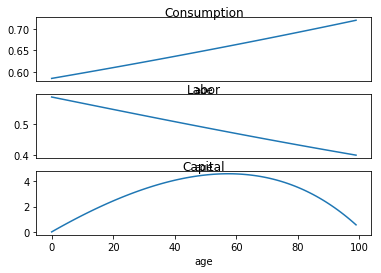

In [17]:
# plot steady state values for consumption, savings and labor
plt.subplot(3, 1, 1)
plt.plot(chist)
plt.title('Consumption', y=.92)
plt.xlabel('age')
plt.xticks([])

plt.subplot(3, 1, 2)
plt.plot(nhist)
plt.title('Labor', y=.92)
plt.xlabel('age')
plt.xticks([])

plt.subplot(3, 1, 3)
plt.plot(khist)
plt.title('Capital', y=.92)
plt.xlabel('age')

plt.show()